# Audio Cleanup Testing
## This denoises (spectral gating), normalizes, trims (by setting a threshold to envelope) and get the cleaned audio file for processing.
## This also prints the waveform of the org audio and waveform, spectrogram, mel spectrogram and mfcc representation of the audio file.

Extracted MFCC Features: (13, 37)


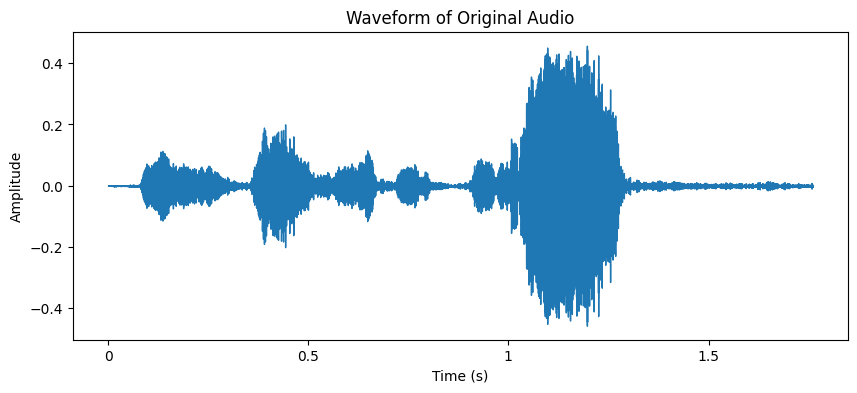

Playing Original Audio:


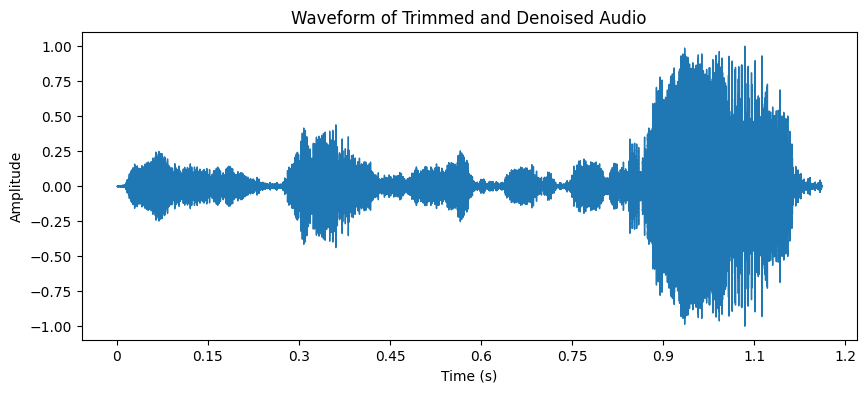

Playing Trimmed and Denoised Audio:


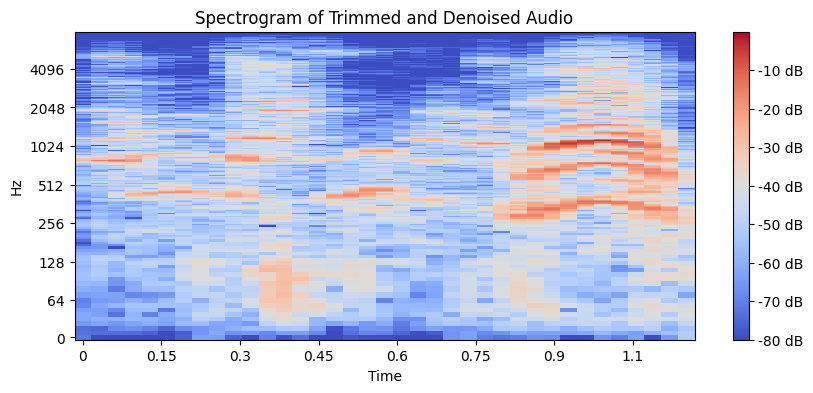

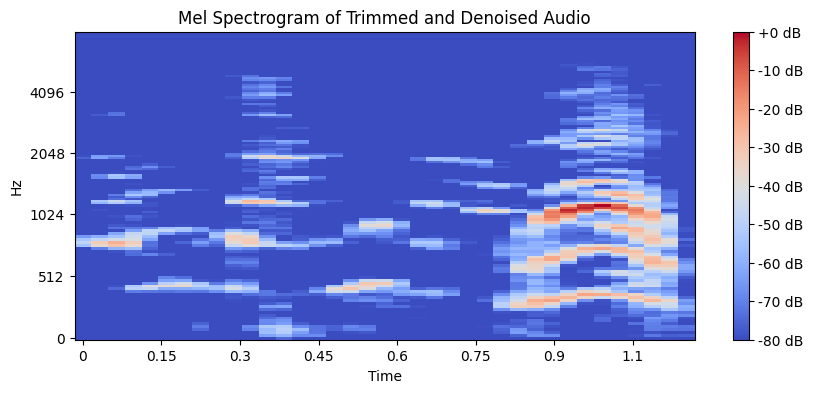

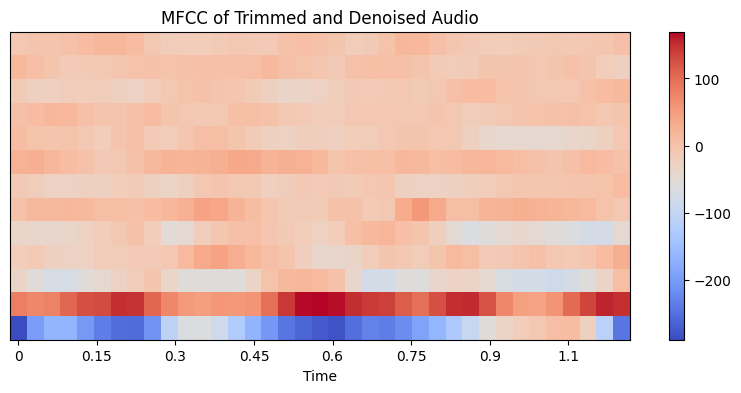

In [7]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pydub import AudioSegment
import IPython.display as ipd

# Constants
audio_file_path = './All/4440/HI_S2_W_0.mp3'  # Path to your audio file
n_mfcc = 13  # Number of MFCC features
threshold = 0.1  # Threshold for envelope function

def convert_mp3_to_wav(mp3_path):
    wav_path = mp3_path.replace('.mp3', '.wav')
    audio = None
    try:
        audio = AudioSegment.from_file(mp3_path, format='mp3')
    except:
        audio = AudioSegment.from_file(mp3_path, format='mp4')
    if audio is None:
        return None
    audio.export(wav_path, format='wav')
    return wav_path

def normalize_audio(y):
    """Normalize audio to the range of -1.0 to 1.0."""
    return y / np.max(np.abs(y)) if np.max(np.abs(y)) != 0 else y

def trim_audio(y):
    """Trim the audio to remove leading and trailing silence."""
    trimmed_audio, _ = librosa.effects.trim(y)
    return trimmed_audio

def envelope(y, rate, threshold):
    mask = []
    y_abs = pd.Series(y).apply(np.abs)  # Convert to absolute values
    y_mean = y_abs.rolling(window=int(rate/10), min_periods=1, center=True).mean()  # Rolling mean
    for mean in y_mean:  # Apply thresholding
        mask.append(mean > threshold)  # Boolean mask
    return np.array(mask)

def spectral_gating(y, sr, noise_factor=0.5, threshold_db=-40):
    """Apply spectral gating for denoising."""
    # Compute the Short-Time Fourier Transform (STFT)
    stft = librosa.stft(y)
    magnitude, phase = librosa.magphase(stft)

    # Convert threshold from dB to linear
    threshold_linear = librosa.db_to_amplitude(threshold_db)

    # Create a mask for noise
    mask = magnitude > threshold_linear
    # Apply noise reduction based on the mask
    magnitude_denoised = magnitude * mask
    # Reconstruct the signal using the modified magnitude and original phase
    stft_denoised = magnitude_denoised * phase
    return librosa.istft(stft_denoised)

def extract_mfcc_features(wav_path, n_mfcc=13, threshold=0.02):
    try:
        audio, sample_rate = librosa.load(wav_path, sr=None)

        # Normalize the audio signal
        audio = normalize_audio(audio)

        # Trim the audio to remove leading and trailing silence
        audio = trim_audio(audio)

        # Apply spectral gating to denoise the audio
        audio = spectral_gating(audio, sample_rate)

        # Apply the envelope function to filter the signal
        mask = envelope(audio, sample_rate, threshold)
        cleaned_audio = audio[mask]  # Filter the signal using the mask

        # Check if the cleaned audio is long enough for MFCC extraction
        if len(cleaned_audio) < 512:  # Minimum length for FFT
            print(f"Warning: Cleaned audio is too short for MFCC extraction.")
            return None

        # Extract MFCC features from the cleaned audio
        mfcc_features = librosa.feature.mfcc(y=cleaned_audio, sr=sample_rate, n_mfcc=n_mfcc)
        return mfcc_features, cleaned_audio, sample_rate
    except Exception as e:
        print(f"Error processing {wav_path}: {e}")
        return None

def plot_waveform(y, sr, title):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

def plot_spectrogram(y, sr, title, n_fft=2048, hop_length=512):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Convert and process the audio file
wav_file_path = convert_mp3_to_wav(audio_file_path)
if wav_file_path:
    mfcc_features, cleaned_audio, sample_rate = extract_mfcc_features(wav_file_path)
    
    if mfcc_features is not None:
        print(f"Extracted MFCC Features: {mfcc_features.shape}")

        # Load the original audio for plotting
        original_audio, _ = librosa.load(wav_file_path, sr=None)
        
        # Plot original audio waveform
        plot_waveform(original_audio, sample_rate, "Waveform of Original Audio")

        # Display original audio player
        print("Playing Original Audio:")
        display(ipd.Audio(wav_file_path))

        # Plot cleaned audio waveform
        plot_waveform(cleaned_audio, sample_rate, "Waveform of Trimmed and Denoised Audio")

        # Display trimmed audio player
        print("Playing Trimmed and Denoised Audio:")
        display(ipd.Audio(cleaned_audio, rate=sample_rate))

        # Plot spectrograms
        plot_spectrogram(cleaned_audio, sample_rate, "Spectrogram of Trimmed and Denoised Audio", n_fft=2048, hop_length=512)

        # Plot Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=cleaned_audio, sr=sample_rate, n_mels=128, fmax=8000)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.amplitude_to_db(mel_spectrogram, ref=np.max), sr=sample_rate, x_axis='time', y_axis='mel', cmap='coolwarm')
        plt.colorbar(format='%+2.0f dB')
        plt.title("Mel Spectrogram of Trimmed and Denoised Audio")
        plt.show()

        # Plot MFCC
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfcc_features, sr=sample_rate, x_axis='time', cmap='coolwarm')
        plt.title("MFCC of Trimmed and Denoised Audio")
        plt.colorbar()
        plt.show()
    else:
        print("MFCC extraction failed.")
else:
    print("Audio conversion failed.")
